In [3]:
import pandas as pd
import numpy as np

import torch
from transformers import BertTokenizer, BertConfig, BertModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from dataset import RelationsDS

data = RelationsDS(root='./data').to(device=device)
data[0]

Data(edge_index=[2, 111276], edge_type=[111276], token_ids=[91294, 147], token_mask=[91294, 147], token_type_ids=[91294, 147])

# BERT encoder

In [10]:
from torch.utils.data import DataLoader

g = data[0].to(device)
tokens = torch.stack([g.token_ids, g.token_mask, g.token_type_ids], dim=1)
tokens.shape

torch.Size([91294, 3, 147])

In [11]:
model = BertModel.from_pretrained('bert-base-uncased').to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [36]:
91294/2, 45647/7

(45647.0, 6521.0)

In [15]:
tokens.shape

torch.Size([91294, 3, 147])

In [19]:
batch_size = 1024
token_loader = DataLoader(tokens, batch_size=batch_size)

encoding_size = 768
x = None

with torch.no_grad():
    for batch_num, token_batch in enumerate(token_loader):
        if batch_num % 10*batch_size == 0:
            print(f'batch {batch_num}/{len(token_loader)}')
        batch_encoding = model(token_batch[:,0,:],
                               token_batch[:,1,:],
                               token_batch[:,2,:]).last_hidden_state[:,0,:]
        if x is None:
            x = batch_encoding
        else:
            x = torch.concat([x, batch_encoding])

batch 0/90
batch 10/90
batch 20/90
batch 30/90
batch 40/90
batch 50/90
batch 60/90
batch 70/90
batch 80/90


In [20]:
x.shape

torch.Size([91294, 768])

In [7]:
with torch.no_grad():
    idx = 0
    id = g.token_ids[idx].unsqueeze(0)
    mask = g.token_mask[idx].unsqueeze(0)
    type_ids = g.token_type_ids[idx].unsqueeze(0)
    print(id.shape, mask.shape, type_ids.shape)

    encoding = model(id, mask, type_ids)

torch.Size([1, 138]) torch.Size([1, 138]) torch.Size([1, 138])


In [5]:
with torch.no_grad():
    num = 10
    id = g.token_ids[:num]
    mask = g.token_mask[:num]
    type_ids = g.token_type_ids[:num]
    print(id.shape, mask.shape, type_ids.shape)

    encoding = model(id, mask, type_ids)

torch.Size([10, 138]) torch.Size([10, 138]) torch.Size([10, 138])


In [10]:
lhs = encoding.last_hidden_state
lhs = lhs[:, 0, :]
lhs = lhs.flatten(start_dim=1)
print(lhs.shape, type(lhs))
print(lhs.mean(), lhs.std())

torch.Size([10, 768]) <class 'torch.Tensor'>
tensor(-0.0102, device='cuda:0') tensor(0.5358, device='cuda:0')


# Model

adapted from [Online Link Prediction with Graph Neural Networks](https://medium.com/stanford-cs224w/online-link-prediction-with-graph-neural-networks-46c1054f2aa4)

In [1]:
from model import Model, LinkPredictor

In [5]:
g = data[0].to(device)
tokens = torch.stack([g.token_ids, g.token_mask, g.token_type_ids], dim=1)

model = Model(input_dim=768,
              hidden_dim=256,
              output_dim=256,
              num_layers=2     ).to(device)
link_pred = LinkPredictor(input_dim=256, 
                          hidden_dim=128,
                          output_dim=1,
                          num_layers=3  ).to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [9]:
with torch.no_grad():
    node_embeddings = model.encode_inputs(tokens) 

In [18]:
torch.save(node_embeddings, 'data/input_encodings.pt')

In [6]:
node_embeddings = model.load_input_encodings().to(device)

In [9]:
g

Data(edge_index=[2, 111276], edge_type=[111276], token_ids=[91294, 147], token_mask=[91294, 147], token_type_ids=[91294, 147])

In [ ]:
emb = model(node_embeddings, g.edge_index)

In [10]:
pred = link_pred(emb[0], emb[1])
pred


tensor([0.5217], device='cuda:0', grad_fn=<SigmoidBackward0>)

# Evaluations

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
res = pd.read_csv('out4.csv')
res

,epoch,train loss,val loss,val precision,val recall
0,1,0.725435,0.724629,0.5,1.0
1,2,0.724585,0.722272,0.5,1.0
2,3,0.722061,0.719212,0.5,1.0
3,4,0.713710,0.717539,0.5,1.0
4,5,0.714085,0.718478,0.5,1.0
...,...,...,...,...,...
495,496,0.693147,0.693147,0.0,0.0
496,497,0.693147,0.693147,0.0,0.0
497,498,0.693147,0.693147,0.0,0.0
498,499,0.693147,0.693147,0.0,0.0


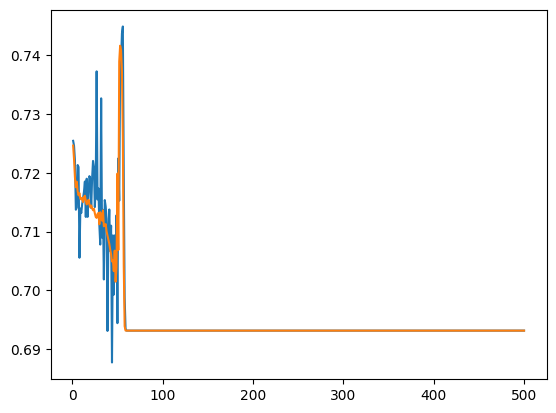

In [24]:
plt.plot(res['epoch'], res['train loss'])
plt.plot(res['epoch'], res['val loss'])
plt.show()

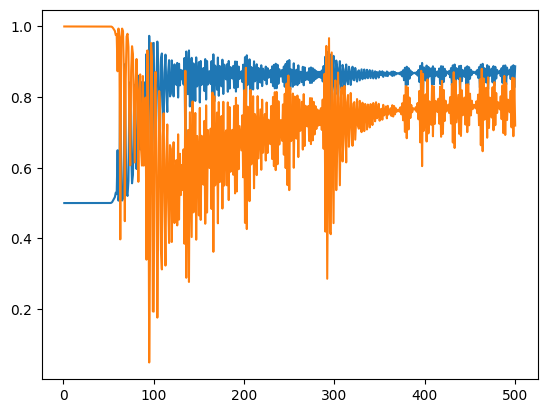

In [22]:
plt.plot(res['epoch'], res['val precision'])
plt.plot(res['epoch'], res['val recall'])
plt.show()